Credit to [Ken Miller](https://www.kaggle.com/mlconsult/1-3816-lb-lbgm-descriptive-stats-param-tune) for the hyper-parameter tuning

Credit to [@columbia2131](https://www.kaggle.com/columbia2131/mlb-lightgbm-starter-dataset-code-en-ja) for the starter code on LightGBM

This notebook uses lightGBM to make predictions.

We use the following features
* playerId
* position
* teamId(rosters)
* status(rosters)
* playerBoxScores

and the date 20200401~20200431 as the validation data.

## About Dataset

Train.csv is stored as a csv file with each column as follows.  

In [ ]:
%%capture

!pip install pandarallel 

import gc

import numpy as np
import pandas as pd
from pathlib import Path

from pandarallel import pandarallel
pandarallel.initialize()

BASE_DIR = Path('../input/mlb-player-digital-engagement-forecasting')
train = pd.read_csv(BASE_DIR / 'train.csv')

null = np.nan
true = True
false = False

for col in train.columns:

    if col == 'date': continue

    _index = train[col].notnull()
    train.loc[_index, col] = train.loc[_index, col].parallel_apply(lambda x: eval(x))

    outputs = []
    for index, date, record in train.loc[_index, ['date', col]].itertuples():
        _df = pd.DataFrame(record)
        _df['index'] = index
        _df['date'] = date
        outputs.append(_df)

    outputs = pd.concat(outputs).reset_index(drop=True)

    outputs.to_csv(f'{col}_train.csv', index=False)
    outputs.to_pickle(f'{col}_train.pkl')

    del outputs
    del train[col]
    gc.collect()

## Exploration


Use small subset of data to test the model implementations

In [89]:
import numpy as np
import statistics as st
from scipy.stats import norm
import pandas as pd
from pathlib import Path
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from datetime import timedelta
from functools import reduce
from tqdm import tqdm
import lightgbm as lgbm
import mlb
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import plotly.express as px
from plotly.subplots import make_subplots
import plotly
import plotly.offline as py
import plotly.graph_objs as go
import cufflinks as cf

In [2]:
BASE_DIR = Path('../input/mlb-player-digital-engagement-forecasting')
TRAIN_DIR = Path('../input/mlb-pdef-train-dataset')
OTHER_DIR = Path('../input/playerfollowersengpkl')

In [9]:
def process_followers(data):
    return data/100000

def calc_stats(player, df, tmp):
    to_append=[pid,'','','','','','','','','','','','','','','','','','','','','','','','']
    targets=['target1','target2','target3','target4']
    i=1
    for target in targets:
        target_prob = tmp[target].tolist()
        mean = np.mean(target_prob)
        std = np.std(target_prob)
        median = st.median(target_prob)
        distribution = norm(mean, std)
        min_weight = min(target_prob)
        max_weight = max(target_prob)
        values = list(np.linspace(min_weight, max_weight))
        probabilities = [distribution.pdf(v) for v in values]
        max_value = max(probabilities)
        max_index = probabilities.index(max_value)
        to_append[i]=mean
        to_append[i+1]=median
        to_append[i+2]=std
        to_append[i+3]=min_weight
        to_append[i+4]=max_weight
        to_append[i+5]=target_prob[max_index]
        i=i+6
    df_length = len(df)
    df.loc[df_length] = to_append
    return df

In [70]:
players = pd.read_csv(BASE_DIR / 'players.csv')
rosters = pd.read_pickle(TRAIN_DIR / 'rosters_train.pkl')
targets = pd.read_pickle(TRAIN_DIR / 'nextDayPlayerEngagement_train.pkl')
scores = pd.read_pickle(TRAIN_DIR / 'playerBoxScores_train.pkl')
scores = scores.groupby(['playerId', 'date']).sum().reset_index()
awards = pd.read_pickle(TRAIN_DIR / 'awards_train.pkl')
dates = pd.DataFrame(data={'date':targets['date'].unique()})
seasons = pd.read_csv(BASE_DIR / 'seasons.csv')
standings = pd.read_pickle(TRAIN_DIR / 'standings_train.pkl')

dates['date_format'] = pd.to_datetime(dates['date'], format="%Y%m%d")
dates['year'] = dates['date_format'].dt.year
dates_info = pd.merge(dates, seasons, left_on='year',right_on='seasonId')
dates_info['in_season'] = dates_info['date_format'].between(dates_info['regularSeasonStartDate'], dates_info['postSeasonEndDate'], inclusive=True)

player_twitter_followers = pd.read_pickle(TRAIN_DIR / 'playerTwitterFollowers_train.pkl')
team_twitter_followers = pd.read_pickle(TRAIN_DIR / 'teamTwitterFollowers_train.pkl')

player_twitter_followers.rename(columns={'numberOfFollowers':'playerFollowers'}, inplace=True)
team_twitter_followers.rename(columns={'numberOfFollowers':'teamFollowers'}, inplace=True)

player_twitter_followers['playerFollowers'] = player_twitter_followers['playerFollowers'].apply(lambda x: process_followers(x))
team_twitter_followers['teamFollowers'] = team_twitter_followers['teamFollowers'].apply(lambda x: process_followers(x))

awards.rename(columns={'awardPlayerTeamId':'teamId'}, inplace=True)

In [ ]:
column_names = ["playerId", "target1_mean","target1_median","target1_std","target1_min","target1_max",
                "target1_prob", "target2_mean","target2_median","target2_std","target2_min","target2_max",
                "target2_prob", "target3_mean","target3_median","target3_std","target3_min","target3_max",
                "target3_prob", "target4_mean","target4_median","target4_std","target4_min","target4_max",
                "target4_prob"]

target_probs = pd.DataFrame(columns=column_names)

for pid in targets.playerId.unique().tolist():
    tmp = targets[targets['playerId']==pid]
    target_stats = calc_stats(pid,target_probs, tmp)

In [103]:
data = go.Bar(y = players.birthCountry.value_counts(),
              x = players.birthCountry.unique(),
              text=players.birthCountry.value_counts(),
              textposition='outside')
fig = go.Figure(data=data)
fig.show()

In [72]:
targets_cols = ['playerId', 'target1', 'target2', 'target3', 'target4', 'date']
players_cols = ['playerId', 'primaryPositionName','mlbDebutDate','birthCountry','playerForTestSetAndFuturePreds']
rosters_cols = ['playerId', 'teamId', 'status', 'date']
date_cols = ['date','in_season']
award_cols = ['playerId','awardId','awardName','awardDate','teamId','date']
player_followers_cols = ['playerId', 'playerFollowers','date']
team_followers_cols = ['teamId','teamFollowers','date']
standing_cols = ['teamId','divisionRank','lastTenWins','lastTenLosses','date']
stats_cols = ["playerId", "target1_mean","target1_median","target1_std","target1_min","target1_max","target1_prob", 
              "target2_mean","target2_median","target2_std","target2_min","target2_max","target2_prob", "target3_mean",
              "target3_median","target3_std","target3_min","target3_max","target3_prob", "target4_mean","target4_median",
              "target4_std","target4_min","target4_max","target4_prob"]
scores_cols = ['playerId', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances', 'date']

In [73]:
awards[award_cols]

,playerId,awardId,awardName,awardDate,teamId,date
0,150119,VWLCPOY,VWL Comeback Player of the Year,2018-01-15,699.0,20180115
1,446861,VWLPOY,VWL Pitcher of the Year,2018-01-15,699.0,20180115
2,492527,VWLMOY,VWL Manager of the Year,2018-01-15,695.0,20180115
3,519246,VWLRLOY,VWL Reliever of the Year,2018-01-15,694.0,20180115
4,543874,VWLOPOY,VWL Offensive Player of the Year,2018-01-15,699.0,20180115
...,...,...,...,...,...,...
5910,660670,NLPOM,NL Player of the Month,2021-04-30,144.0,20210430
5911,598264,ALRRELMON,AL Reliever of the Month,2021-04-30,111.0,20210430
5912,621439,ALPOM,AL Player of the Month,2021-04-30,142.0,20210430
5913,606213,ALROM,AL Rookie of the Month,2021-04-30,145.0,20210430


In [74]:
from sklearn.preprocessing import LabelEncoder

# create dataset

# only use true for preds players 
train_players = players[players['playerForTestSetAndFuturePreds'] == True]['playerId'].values
train = targets[targets_cols].merge(players[players_cols], on=['playerId'], how='left')
train = train[train['playerId'].isin(train_players).reset_index(drop=True)]

# merge
train = train.merge(rosters[rosters_cols], on=['playerId', 'date'], how='left')
train = train.merge(scores[scores_cols], on=['playerId', 'date'], how='left')
#doesnt work as of rn
train = train.merge(awards[award_cols], on=['playerId','date','teamId'],how='left')

train = train.merge(player_twitter_followers[player_followers_cols], on=['playerId','date'], how='left')
train = train.merge(team_twitter_followers[team_followers_cols], on=['teamId','date'], how='left')
train = train.merge(standings[standing_cols], on=['teamId','date'], how='left')
train = train.merge(dates_info[date_cols], on=['date'],how='left')
train = train.merge(target_stats[stats_cols],on=['playerId'],how='left')
train['divisionRank'] = train['divisionRank'].fillna(-1)
train['divisionRank'] = train['divisionRank'].astype(int)

# label encoding
le = LabelEncoder()
player2num = {c: i for i, c in enumerate(train['playerId'].unique())}
position2num = {c: i for i, c in enumerate(train['primaryPositionName'].unique())}
teamid2num = {c: i for i, c in enumerate(train['teamId'].unique())}
status2num = {c: i for i, c in enumerate(train['status'].unique())}
awards2num = {c: i for i, c in enumerate(train['awardId'].unique())}
train['award_type'] = le.fit_transform(train['awardName'])
train['birth_country_num'] = le.fit_transform(train['birthCountry'])
train['label_playerId'] = train['playerId'].map(player2num)
train['label_primaryPositionName'] = train['primaryPositionName'].map(position2num)
train['label_teamId'] = train['teamId'].map(teamid2num)
train['label_status'] = train['status'].map(status2num)
train['label_awards'] = train['awardId'].map(awards2num)
train['playerFollowers'] = train['playerFollowers'].fillna(0)
train['teamFollowers'] = train['teamFollowers'].fillna(0)
train['time_in_league'] = pd.to_datetime(train['date'],format="%Y%m%d") - pd.to_datetime(train['mlbDebutDate'])
train['time_in_league'] = train['time_in_league'].dt.days
train['time_since_award'] = pd.to_datetime(train['date'],format="%Y%m%d") - pd.to_datetime(train['awardDate'])
train['time_since_award'] = train['time_since_award'].dt.days

        awardId awardDate
0           NaN       NaN
1           NaN       NaN
2           NaN       NaN
3           NaN       NaN
4           NaN       NaN
...         ...       ...
1443410     NaN       NaN
1443411     NaN       NaN
1443412     NaN       NaN
1443413     NaN       NaN
1443414     NaN       NaN

[1443415 rows x 2 columns]


KeyboardInterrupt: 

In [24]:
feature_cols = ['label_playerId', 'label_primaryPositionName', 'label_teamId',
       'label_status', 'battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances','playerFollowers','teamFollowers',
       'in_season','time_in_league','time_since_award','award_type','divisionRank',
       'lastTenWins','lastTenLosses','birth_country_num']

### Correlation Matrix for features

In [35]:
altered_train = train.copy()
altered_train['target_avg'] = np.mean(train[['target1', 'target2', 'target3', 'target4']], axis=1)

In [ ]:
train_corr = altered_train.corr()
train_corr

In [ ]:
altered_train['target_avg'].corr(altered_train['teamFollowers'])

In [36]:
box_scores = altered_train[['battingOrder', 'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances','target_avg']]
box_scores_corr = box_scores.corr()
fig = px.imshow(box_scores_corr)
fig.show()

In [42]:
standing_cols = altered_train[['teamId','divisionRank','lastTenWins','lastTenLosses','date','target_avg']]
standing_corr = standing_cols.corr()
fig = px.imshow(standing_corr)
fig.show()

In [43]:
player_corr_cols = altered_train[['playerId', 'primaryPositionName','mlbDebutDate','birthCountry','playerForTestSetAndFuturePreds','birth_country_num','label_playerId',
                                 'time_in_league','label_primaryPositionName','target_avg']]
player_corr = player_corr_cols.corr()
fig = px.imshow(player_corr)
fig.show()

In [44]:
award_corr_cols = altered_train[['playerId', 'award_type','awardName','awardId','label_awards','time_since_award','target_avg']]
award_corr = award_corr_cols.corr()
fig = px.imshow(award_corr)
fig.show()

In [ ]:
def assess_correlation(col_set):
    corr_scores = {'col':'score'}
    for col in col_set:
        corr_scores[col] = altered_train['target_avg'].corr(altered_train[col])
    return corr_scores

In [ ]:
scores_corr = assess_correlation(scores_cols)


## Training

In [25]:
train_X = train[feature_cols]
train_y = train[['target1', 'target2', 'target3', 'target4']]

_index = (train['date'] < 20210401)
x_train = train_X.loc[_index].reset_index(drop=True)
y_train = train_y.loc[_index].reset_index(drop=True)
x_valid = train_X.loc[~_index].reset_index(drop=True)
y_valid = train_y.loc[~_index].reset_index(drop=True)

# LightGBM Model

LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:

* Faster training speed and higher efficiency.

* Lower memory usage.

* Better accuracy.

* Support of parallel, distributed, and GPU learning.

* Capable of handling large-scale data.


[More Info LightGBM Parameters](https://lightgbm.readthedocs.io/en/latest/Parameters.html)

### Hyperparameter Tuning

In [26]:
import optuna

# Define objectives for the study
def lgbm_objective1(trial):

    param = {
     'objective': 'huber',
     'metric': 'mae',
     'verbosity': -1,
     'boosting_type': 'gbdt',
     'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
     'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
     'num_leaves': trial.suggest_int('num_leaves', 2, 256),
     'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
     'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
     'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
     'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
      'n_estimators': 100,
     'feature_pre_filter':False
    }

    gbm = lgbm.train(param, train_data1)
    preds = gbm.predict(x_valid)
    score = mean_absolute_error(preds, y_valid['target1'])

    return score

def lgbm_objective2(trial):

    param = {
     'objective': 'huber',
     'metric': 'mae',
     'verbosity': -1,
     'boosting_type': 'gbdt',
     'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
     'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
     'num_leaves': trial.suggest_int('num_leaves', 2, 256),
     'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
     'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
     'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
     'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
      'n_estimators': 100,
     'feature_pre_filter':False
    }

    gbm = lgbm.train(param, train_data2)
    preds = gbm.predict(x_valid)
    score = mean_absolute_error(preds, y_valid['target2'])

    return score


def lgbm_objective3(trial):

    param = {
     'objective': 'huber',
     'metric': 'mae',
     'verbosity': -1,
     'boosting_type': 'gbdt',
     'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
     'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
     'num_leaves': trial.suggest_int('num_leaves', 2, 256),
     'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
     'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
     'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
     'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
      'n_estimators': 100,
     'feature_pre_filter':False
    }

    gbm = lgbm.train(param, train_data3)
    preds = gbm.predict(x_valid)
    score = mean_absolute_error(preds, y_valid['target3'])

    return score

def lgbm_objective4(trial):

    param = {
     'objective': 'huber',
     'metric': 'mae',
     'verbosity': -1,
     'boosting_type': 'gbdt',
     'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
     'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
     'num_leaves': trial.suggest_int('num_leaves', 2, 256),
     'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
     'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
     'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
     'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
      'n_estimators': 100,
     'feature_pre_filter':False
    }

    gbm = lgbm.train(param, train_data4)
    preds = gbm.predict(x_valid)
    score = mean_absolute_error(preds, y_valid['target4'])

    return score

In [ ]:
train_data1 = lgbm.Dataset(x_train, label=y_train['target1'])
train_data2 = lgbm.Dataset(x_train, label=y_train['target2'])
train_data3 = lgbm.Dataset(x_train, label=y_train['target3'])
train_data4 = lgbm.Dataset(x_train, label=y_train['target4'])

In [ ]:
study1 = optuna.create_study(direction='minimize')
study1.optimize(lgbm_objective1, n_trials=5,gc_after_trial=True)

In [ ]:
study2 = optuna.create_study(direction='minimize')
study2.optimize(lgbm_objective2, n_trials=5,gc_after_trial=True)

In [ ]:
study3 = optuna.create_study(direction='minimize')
study3.optimize(lgbm_objective3, n_trials=5,gc_after_trial=True,n_jobs=-1)

In [ ]:
study4 = optuna.create_study(direction='minimize')
study4.optimize(lgbm_objective4, n_trials=5,gc_after_trial=True,n_jobs=-1)

In [ ]:
lgbm_params1 = study1.best_params
lgbm_params2 = study2.best_params
lgbm_params3 = study3.best_params
lgbm_params4 = study4.best_params

In [ ]:
print("+"*30)
print("Params 1:",lgbm_params1)
print("+"*30)
print("Params 2:",lgbm_params2)
print("+"*30)
print("Params 3:",lgbm_params3)
print("+"*30)
print("Params 4:",lgbm_params4)

### Model Training

In [27]:
%%time

import warnings
warnings.filterwarnings("ignore")

def fit_lgbm(x_train, y_train, x_valid, y_valid, params: dict=None, verbose=100):
    oof_pred = np.zeros(len(y_valid), dtype=np.float32)
    model = lgbm.LGBMRegressor(**params)
    model.fit(x_train, y_train, 
        eval_set=[(x_valid, y_valid)],  
        early_stopping_rounds=verbose, 
        verbose=False)
    oof_pred = model.predict(x_valid)
    score = mean_absolute_error(oof_pred, y_valid)
    mse = mean_squared_error(oof_pred, y_valid)
    print('mae:', score)
    print('mse:', mse)
    return oof_pred, model, score


# training lightgbm


params1 = {
 'objective':'huber',
 'metric':'mae',
 'lambda_l1': 2.4720578317437477e-05,
 'lambda_l2': 1.3527755261208504e-06,
 'num_leaves': 40,
 'feature_fraction': 0.7554047245795381,
 'bagging_fraction': 0.5080066015078072,
 'bagging_freq': 3,
 'min_child_samples': 100
          }
params2 = {
 'objective':'huber',
 'metric':'mae',
 'lambda_l1': 0.0014725905491640504,
 'lambda_l2': 5.713092762240107,
 'num_leaves': 47,
 'feature_fraction': 0.462021949863225,
 'bagging_fraction': 0.4500482872517192,
 'bagging_freq': 4,
 'min_child_samples': 24
         }
params3 = {
 'objective':'huber',
 'metric':'mae',
 'lambda_l1': 1.646629475621938e-07,
 'lambda_l2': 0.00020089914770634004,
 'num_leaves': 42,
 'feature_fraction': 0.6792583947012405,
 'bagging_fraction': 0.4772814797729401,
 'bagging_freq': 4,
 'min_child_samples': 99
        }
params4 = {
 'objective':'huber',
 'metric':'mae',
 'lambda_l1': 0.007010740786027014,
 'lambda_l2': 8.864818411173501e-08,
 'num_leaves': 46,
 'feature_fraction': 0.6146671105020214,
 'bagging_fraction': 0.7314001423885812,
 'bagging_freq': 2,
 'min_child_samples': 75
          }

oof1, lgbm_model1, score1 = fit_lgbm(
    x_train, y_train['target1'],
    x_valid, y_valid['target1'],
    params1
)
oof2, lgbm_model2, score2 = fit_lgbm(
    x_train, y_train['target2'],
    x_valid, y_valid['target2'],
    params2
)
oof3, lgbm_model3, score3 = fit_lgbm(
    x_train, y_train['target3'],
    x_valid, y_valid['target3'],
    params3
)
oof4, lgbm_model4, score4 = fit_lgbm(
    x_train, y_train['target4'],
    x_valid, y_valid['target4'],
    params4
)

score = (score1+score2+score3+score4) / 4
print(f'score: {score}')

mae: 1.2915092387972553
mse: 33.511298138164626
[LightGBM] [Warning] lambda_l1 is set=0.0014725905491640504, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0014725905491640504
[LightGBM] [Warning] bagging_fraction is set=0.4500482872517192, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4500482872517192
[LightGBM] [Warning] lambda_l2 is set=5.713092762240107, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.713092762240107
[LightGBM] [Warning] feature_fraction is set=0.462021949863225, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.462021949863225
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
mae: 2.597929143237744
mse: 58.1352967818876
[LightGBM] [Warning] lambda_l1 is set=1.646629475621938e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.646629475621938e-07
[LightGBM] [Warning] bagging_fraction is set=0.4772814797729401, subsample=1.0 will be ign

<AxesSubplot:title={'center':'Target 1 Feature Importance'}, xlabel='Feature importance', ylabel='Features'>

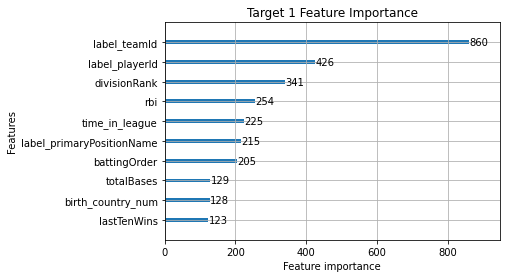

In [28]:
lgbm.plot_importance(lgbm_model1,ignore_zero=True, max_num_features=10,title='Target 1 Feature Importance')

<AxesSubplot:title={'center':'Target 2 Feature Importance'}, xlabel='Feature importance', ylabel='Features'>

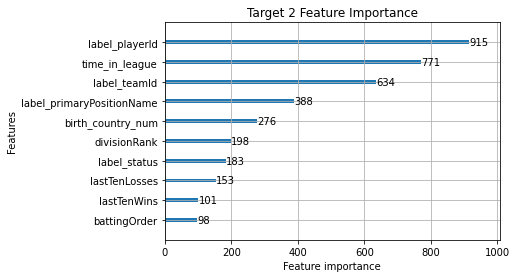

In [29]:
lgbm.plot_importance(lgbm_model2,ignore_zero=True, max_num_features=10,title='Target 2 Feature Importance')

<AxesSubplot:title={'center':'Target 3 Feature Importance'}, xlabel='Feature importance', ylabel='Features'>

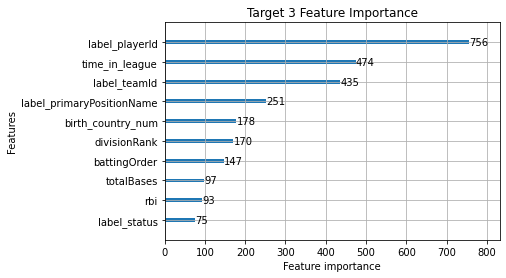

In [30]:
lgbm.plot_importance(lgbm_model3,ignore_zero=True, max_num_features=10,title='Target 3 Feature Importance')

<AxesSubplot:title={'center':'Target 4 Feature Importance'}, xlabel='Feature importance', ylabel='Features'>

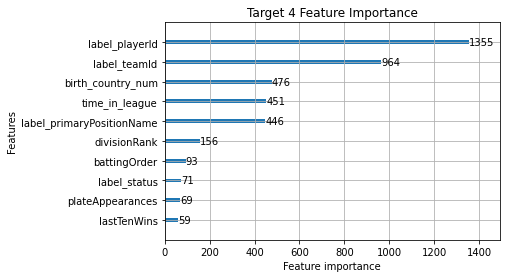

In [31]:
lgbm.plot_importance(lgbm_model4,ignore_zero=True, max_num_features=10,title='Target 4 Feature Importance')

### Cross Validation

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

kfold_cv = KFold(n_splits=10)
target1_score = cross_val_score(lgbm_model1, x_train, y_train['target1'], scoring='neg_mean_absolute_error', cv=kfold_cv)
target2_score = cross_val_score(lgbm_model2, x_train, y_train['target2'], scoring='neg_mean_absolute_error', cv=kfold_cv)
target3_score = cross_val_score(lgbm_model3, x_train, y_train['target3'], scoring='neg_mean_absolute_error', cv=kfold_cv)
target4_score = cross_val_score(lgbm_model4, x_train, y_train['target4'], scoring='neg_mean_absolute_error', cv=kfold_cv)

In [33]:
print("Target1 CV Score: ", target1_score)
print("Target2 CV Score: ", target2_score)
print("Target3 CV Score: ", target3_score)
print("Target4 CV Score: ", target4_score)

Target1 CV Score:  [-0.54284433 -1.01798546 -0.67650314 -0.83703432 -0.97080949 -0.78077136
 -0.75252345 -0.66124057 -0.78146361 -0.92484265]
Target2 CV Score:  [-2.06735289 -2.04740638 -1.68864822 -2.30727431 -2.4727203  -2.11399259
 -3.23360512 -3.41761458 -2.39872796 -2.54448027]
Target3 CV Score:  [-0.92637206 -1.11890517 -0.77357821 -0.87009136 -1.16736435 -1.05019527
 -1.12012866 -0.99747152 -0.88104602 -1.04951927]
Target4 CV Score:  [-0.93890902 -1.21604002 -0.84640197 -0.94747587 -1.10210179 -1.11824218
 -1.20148718 -0.77878559 -1.16206722 -1.27443093]


In [34]:
print("Target1 CV Score: ", abs(np.mean(target1_score)))
print("Target2 CV Score: ", abs(np.mean(target2_score)))
print("Target3 CV Score: ", abs(np.mean(target3_score)))
print("Target4 CV Score: ", abs(np.mean(target4_score)))

Target1 CV Score:  0.7946018374924868
Target2 CV Score:  2.429182261417959
Target3 CV Score:  0.9954671889282528
Target4 CV Score:  1.0585941766352482


In [ ]:
(0.7946018374924867 +2.429182261417959+0.9954672655620641+1.0585941766352485)/4

# XGBoost Implementation

### Hyper Parameter Tuning using Optuna

In [ ]:
import xgboost as xgb
# Define objectives for the study
def xgb_objective1(trial):

    param = {
     'objective': 'reg:squarederror',
     'lambda': trial.suggest_loguniform('lamda',1e-3,10.0),
     'alpha': trial.suggest_loguniform('lamda',1e-3,10.0),
     'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02]),
     'n_estimators': trial.suggest_categorical("n_estimators", [150, 200, 300, 3000]),
    }

    model = xgb.XGBRegressor(**param)
    xb = model.fit(x_train, y_train['target1'], eval_set=[(x_valid, y_valid['target1'])], early_stopping_rounds=100, verbose=False  )
    preds = xb.predict(x_valid)
    score = mean_absolute_error(preds, y_valid['target1'])

    return score

def xgb_objective2(trial):

    param = {
     'objective': 'reg:squarederror',
     'lambda': trial.suggest_loguniform('lamda',1e-3,10.0),
     'alpha': trial.suggest_loguniform('lamda',1e-3,10.0),
     'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02]),
     'n_estimators': trial.suggest_categorical("n_estimators", [150, 200, 300, 3000]),
    }

    model = xgb.XGBRegressor(**param)
    xb = model.fit(x_train, y_train['target2'], eval_set=[(x_valid, y_valid['target2'])], early_stopping_rounds=100, verbose=False  )
    preds = xb.predict(x_valid)
    score = mean_absolute_error(preds, y_valid['target2'])

    return score


def xgb_objective3(trial):

    param = {
     'objective': 'reg:squarederror',
     'lambda': trial.suggest_loguniform('lamda',1e-3,10.0),
     'alpha': trial.suggest_loguniform('lamda',1e-3,10.0),
     'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02]),
     'n_estimators': trial.suggest_categorical("n_estimators", [150, 200, 300, 3000]),
    }
    
    model = xgb.XGBRegressor(**param)
    xb = model.fit(x_train, y_train['target3'], eval_set=[(x_valid, y_valid['target3'])], early_stopping_rounds=100, verbose=False  )
    preds = xb.predict(x_valid)
    score = mean_absolute_error(preds, y_valid['target3'])

    return score

def xgb_objective4(trial):

    param = {
     'objective': 'reg:squarederror',
     'lambda': trial.suggest_loguniform('lamda',1e-3,10.0),
     'alpha': trial.suggest_loguniform('lamda',1e-3,10.0),
     'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.009,0.01,0.012,0.014,0.016,0.018, 0.02]),
     'n_estimators': trial.suggest_categorical("n_estimators", [150, 200, 300, 3000]),
    }
    model = xgb.XGBRegressor(**param)
    xb = model.fit(x_train, y_train['target4'], eval_set=[(x_valid, y_valid['target4'])], early_stopping_rounds=100, verbose=False  )
    preds = xb.predict(x_valid)
    score = mean_absolute_error(preds, y_valid['target4'])

    return score

In [ ]:
study1 = optuna.create_study(direction='minimize')
study1.optimize(xgb_objective1, n_trials=5,gc_after_trial=True)

In [ ]:
study2 = optuna.create_study(direction='minimize')
study2.optimize(xgb_objective2, n_trials=5,gc_after_trial=True)

In [ ]:
study3 = optuna.create_study(direction='minimize')
study3.optimize(xgb_objective3, n_trials=5,gc_after_trial=True)

In [ ]:
study4 = optuna.create_study(direction='minimize')
study4.optimize(xgb_objective4, n_trials=5,gc_after_trial=True)

### Model Training

In [ ]:
%%time
# way to speed this up perhaps?
#implement separate mae function
def fit_xgboost(x_train, y_train, x_valid, y_valid, params: dict=None):
    oof_pred = np.zeros(len(y_valid), dtype=np.float32)
    model = xgb.XGBRegressor(objective="reg:squarederror",
                             max_depth=6,
                             n_estimators=100,
                             grow_policy='lossguide',
                             learning_rate=0.1)
    print("Fitting XGBoostRegressor: ")
    model.fit(x_train, y_train, eval_set=([x_train, y_train],[x_valid, y_valid]),eval_metric="mae",early_stopping_rounds=100,verbose=20)
    oof_pred = model.predict(x_valid)
    score = mean_absolute_error(oof_pred, y_valid)
    mse = mean_squared_error(oof_pred, y_valid)
    print('mae:', score)
    print('mse:', mse)
    return oof_pred, model, score


params = {
             objective="reg:squarederror",
             max_depth=6,
             n_estimators=100,
             grow_policy='lossguide',
             learning_rate=0.1
        }


oof1, xg_model1, score1 = fit_xgboost(
    x_train, y_train['target1'],
    x_valid, y_valid['target1'],
    #params
)
oof2, xg_model2, score2 = fit_xgboost(
    x_train, y_train['target2'],
    x_valid, y_valid['target2'],
    #params
)
oof3, xg_model3, score3 = fit_xgboost(
    x_train, y_train['target3'],
    x_valid, y_valid['target3'],
    #params
)
oof4, xg_model4, score4 = fit_xgboost(
    x_train, y_train['target4'],
    x_valid, y_valid['target4'],
    #params
)

score = (score1+score2+score3+score4) / 4
print(f'score: {score}')

In [ ]:
%%time
xg_target1_score = cross_val_score(xg_model1, x_train, y_train['target1'], scoring='neg_mean_absolute_error', cv=kfold_cv)
xg_target2_score = cross_val_score(xg_model2, x_train, y_train['target2'], scoring='neg_mean_absolute_error', cv=kfold_cv)
xg_target3_score = cross_val_score(xg_model3, x_train, y_train['target3'], scoring='neg_mean_absolute_error', cv=kfold_cv)
xg_target4_score = cross_val_score(xg_model4, x_train, y_train['target4'], scoring='neg_mean_absolute_error', cv=kfold_cv)

In [ ]:
print("Target1 CV Score: ", xg_target1_score)
print("Target2 CV Score: ", xg_target2_score)
print("Target3 CV Score: ", xg_target3_score)
print("Target4 CV Score: ", xg_target4_score)

In [ ]:
print("Target1 CV Score: ", abs(np.mean(xg_target1_score)))
print("Target2 CV Score: ", abs(np.mean(xg_target2_score)))
print("Target3 CV Score: ", abs(np.mean(xg_target3_score)))
print("Target4 CV Score: ", abs(np.mean(xg_target4_score)))

In [ ]:
params = {'objective':"reg:squarederror",
             'max_depth':6,
             'n_estimators':100,
             'grow_policy':'lossguide',
             'learning_rate':0.1
         }
xg_train1 = xgb.DMatrix(x_train, label=y_train['target1'])
xg_train2 = xgb.DMatrix(x_train, label=y_train['target2'])
xg_train3 = xgb.DMatrix(x_train, label=y_train['target3'])
xg_train4 = xgb.DMatrix(x_train, label=y_train['target4'])

cv1 = xgb.cv(params, xg_train1, nfold=10)
cv2 = xgb.cv(params, xg_train2, nfold=10)
cv3 = xgb.cv(params, xg_train3, nfold=10)
cv4 = xgb.cv(params, xg_train4, nfold=10)

In [ ]:
cv1 = cv1['train-rmse-mean'].mean()
cv2 = cv2['train-rmse-mean'].mean()
cv3 = cv3['train-rmse-mean'].mean()
cv4 = cv4['train-rmse-mean'].mean()

print("Target1 CV Score: ", cv1)
print("Target2 CV Score: ", cv2)
print("Target3 CV Score: ", cv3)
print("Target4 CV Score: ", cv4)

# 

# Cat Boosting

In [ ]:
%%time
from catboost import CatBoostRegressor

def fit_catboost(x_train, y_train, x_valid, y_valid):
    oof_pred = np.zeros(len(y_valid), dtype=np.float32)
    model = CatBoostRegressor(
                    n_estimators=2000,
                    learning_rate=0.05,
                    loss_function='MAE',
                    eval_metric='MAE',
                    max_bin=50,
                    subsample=0.9,
                    colsample_bylevel=0.5,
                    verbose=100)
    model.fit(x_train, y_train, use_best_model=True,
                         eval_set=(x_valid, y_valid),
                         early_stopping_rounds=25)

    oof_pred = model.predict(x_valid)
    score = mean_absolute_error(oof_pred, y_valid)
    mse = mean_squared_error(oof_pred, y_valid)
    print('mae:', score)
    print('mse:', mse)
    return oof_pred, model, score



oof1, cat_model1, score1 = fit_catboost(
    x_train, y_train['target1'],
    x_valid, y_valid['target1'],
    #params
)
oof2, cat_model2, score2 = fit_catboost(
    x_train, y_train['target2'],
    x_valid, y_valid['target2'],
    #params
)
oof3, cat_model3, score3 = fit_catboost(
    x_train, y_train['target3'],
    x_valid, y_valid['target3'],
    #params
)
oof4, cat_model4, score4 = fit_catboost(
    x_train, y_train['target4'],
    x_valid, y_valid['target4'],
    #params
)

score = (score1+score2+score3+score4) / 4
print(f'score: {score}')

In [ ]:
%%time
cat_target1_score = cross_val_score(cat_model1, x_train, y_train['target1'], scoring='neg_mean_absolute_error', cv=kfold_cv)
cat_target2_score = cross_val_score(cat_model2, x_train, y_train['target2'], scoring='neg_mean_absolute_error', cv=kfold_cv)
cat_target3_score = cross_val_score(cat_model3, x_train, y_train['target3'], scoring='neg_mean_absolute_error', cv=kfold_cv)
cat_target4_score = cross_val_score(cat_model4, x_train, y_train['target4'], scoring='neg_mean_absolute_error', cv=kfold_cv)

In [ ]:
print("Target1 CV Score: ", abs(min(cat_target1_score)))
print("Target2 CV Score: ", abs(min(cat_target2_score)))
print("Target3 CV Score: ", abs(min(cat_target3_score)))
print("Target4 CV Score: ", abs(min(cat_target4_score)))

## Inference

In [ ]:
players_cols = ['playerId', 'primaryPositionName']
rosters_cols = ['playerId', 'teamId', 'status']
scores_cols = ['playerId', 'battingOrder',    'gamesPlayedBatting', 'flyOuts',
       'groundOuts', 'runsScored', 'doubles', 'triples', 'homeRuns',
       'strikeOuts', 'baseOnBalls', 'intentionalWalks', 'hits', 'hitByPitch',
       'atBats', 'caughtStealing', 'stolenBases', 'groundIntoDoublePlay',
       'groundIntoTriplePlay', 'plateAppearances', 'totalBases', 'rbi',
       'leftOnBase', 'sacBunts', 'sacFlies', 'catchersInterference',
       'pickoffs', 'gamesPlayedPitching', 'gamesStartedPitching',
       'completeGamesPitching', 'shutoutsPitching', 'winsPitching',
       'lossesPitching', 'flyOutsPitching', 'airOutsPitching',
       'groundOutsPitching', 'runsPitching', 'doublesPitching',
       'triplesPitching', 'homeRunsPitching', 'strikeOutsPitching',
       'baseOnBallsPitching', 'intentionalWalksPitching', 'hitsPitching',
       'hitByPitchPitching', 'atBatsPitching', 'caughtStealingPitching',
       'stolenBasesPitching', 'inningsPitched', 'saveOpportunities',
       'earnedRuns', 'battersFaced', 'outsPitching', 'pitchesThrown', 'balls',
       'strikes', 'hitBatsmen', 'balks', 'wildPitches', 'pickoffsPitching',
       'rbiPitching', 'gamesFinishedPitching', 'inheritedRunners',
       'inheritedRunnersScored', 'catchersInterferencePitching',
       'sacBuntsPitching', 'sacFliesPitching', 'saves', 'holds', 'blownSaves',
       'assists', 'putOuts', 'errors', 'chances']

null = np.nan
true = True
false = False

env = mlb.make_env() # initialize the environment
iter_test = env.iter_test() # iterator which loops over each date in test set

for (test_df, sample_prediction_df) in iter_test: # make predictions here
    
    sample_prediction_df = sample_prediction_df.reset_index(drop=True)
    
    # creat dataset
    sample_prediction_df['playerId'] = sample_prediction_df['date_playerId']\
                                        .map(lambda x: int(x.split('_')[1]))
    # Dealing with missing values
    if test_df['rosters'].iloc[0] == test_df['rosters'].iloc[0]:
        test_rosters = pd.DataFrame(eval(test_df['rosters'].iloc[0]))
    else:
        test_rosters = pd.DataFrame({'playerId': sample_prediction_df['playerId']})
        for col in rosters.columns:
            if col == 'playerId': continue
            test_rosters[col] = np.nan
            
    if test_df['playerBoxScores'].iloc[0] == test_df['playerBoxScores'].iloc[0]:
        test_scores = pd.DataFrame(eval(test_df['playerBoxScores'].iloc[0]))
    else:
        test_scores = pd.DataFrame({'playerId': sample_prediction_df['playerId']})
        for col in scores.columns:
            if col == 'playerId': continue
            test_scores[col] = np.nan
    test_scores = test_scores.groupby('playerId').sum().reset_index()
    test = sample_prediction_df[['playerId']].copy()
    test = test.merge(players[players_cols], on='playerId', how='left')
    test = test.merge(test_rosters[rosters_cols], on='playerId', how='left')
    test = test.merge(test_scores[scores_cols], on='playerId', how='left')

    test['label_playerId'] = test['playerId'].map(player2num)
    test['label_primaryPositionName'] = test['primaryPositionName'].map(position2num)
    test['label_teamId'] = test['teamId'].map(teamid2num)
    test['label_status'] = test['status'].map(status2num)
    
    test_X = test[feature_cols]
    
    # predict
    pred1 = model1.predict(test_X)
    pred2 = model2.predict(test_X)
    pred3 = model3.predict(test_X)
    pred4 = model4.predict(test_X)
    
    # merge submission
    sample_prediction_df['target1'] = np.clip(pred1, 0, 100)
    sample_prediction_df['target2'] = np.clip(pred2, 0, 100)
    sample_prediction_df['target3'] = np.clip(pred3, 0, 100)
    sample_prediction_df['target4'] = np.clip(pred4, 0, 100)
    sample_prediction_df = sample_prediction_df.fillna(0.)
    del sample_prediction_df['playerId']
    
    env.predict(sample_prediction_df)